In [1]:
# Install necessary libraries (run once)
!pip install -U transformers datasets scikit-learn huggingface_hub fsspec matplotlib seaborn
!pip install nltk

# Imports for data handling, NLP, modeling, and visualization
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer

# Download necessary NLTK resources (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Initialize stemmer and stopwords
lancaster_stemmer = LancasterStemmer()
stops = set(stopwords.words('english'))
punctuation = set(string.punctuation)

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the sentiment analysis pipeline
# Uses the specified pretrained multilingual BERT model
# 'truncation' set to 'only_first' to truncate only the first sequence in case of pair inputs
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    truncation='only_first'
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


In [3]:
# Load the IMDB dataset from the Hugging Face Hub
dataset = load_dataset("stanfordnlp/imdb")

# Create two copies of the dataset for separate processing
dataset_normale = dataset.copy()
dataset_processato = dataset.copy()

print("IMDB dataset loaded and copied successfully.")

IMDB dataset loaded and copied successfully.


In [4]:
def analyze_and_evaluate(dataset, split):
    """
    Analyzes sentiment of a dataset split using the sentiment_analyzer pipeline
    and calculates evaluation metrics.

    Args:
        dataset: The dataset object.
        split: The split of the dataset to analyze (e.g., 'test').

    Returns:
        A dictionary containing evaluation metrics.
    """
    texts = dataset[split]['text']
    true_labels = dataset[split]['label']

    # Analyze sentiment
    results = sentiment_analyzer(texts)

    # Map model output to binary labels (0 for negative, 1 for positive)
    predicted_labels = []
    for res in results:
        label = res['label']
        if label in ['1 star', '2 stars', '3 stars']: # Assuming 3 stars is also leaning negative or neutral mapped to negative
             predicted_labels.append(0)
        elif label in ['4 stars', '5 stars']:
             predicted_labels.append(1)
        else:
            # Handle unexpected labels if necessary, though unlikely for this model
            print(f"Warning: Unexpected label '{label}'")
            predicted_labels.append(0) # Default to negative

    # Ensure the lengths match
    if len(predicted_labels) != len(true_labels):
        print("Error: Mismatch between predicted and true labels length.")
        return {}

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    report = classification_report(true_labels, predicted_labels)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "classification_report": report
    }

In [5]:
# Analyze the test split of the original dataset
print("\nAnalyzing the test split of the original dataset:")
evaluation_results_normale = analyze_and_evaluate(dataset_normale, 'test')

if evaluation_results_normale:
    print(f"Accuracy: {evaluation_results_normale['accuracy']:.4f}")
    print(f"Precision: {evaluation_results_normale['precision']:.4f}")
    print(f"Recall: {evaluation_results_normale['recall']:.4f}")
    print(f"F1-score: {evaluation_results_normale['f1_score']:.4f}")
    print("\nClassification Report:")
    print(evaluation_results_normale['classification_report'])


Analyzing the test split of the original dataset:
Accuracy: 0.8491
Precision: 0.9257
Recall: 0.7591
F1-score: 0.8342

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.86     12500
           1       0.93      0.76      0.83     12500

    accuracy                           0.85     25000
   macro avg       0.86      0.85      0.85     25000
weighted avg       0.86      0.85      0.85     25000



In [6]:
# Function to remove URLs from text
def remove_urls(text):
    if isinstance(text, str):
        # More comprehensive pattern to match various URL formats
        url_pattern = re.compile(r'https?://[^\s<>"{}|\\^`$begin:math:display$$end:math:display$]*')
        text_mod = url_pattern.sub('', text).strip()  # Remove URLs and trim whitespace
        return text_mod
    return text  # Return original if not a string

# Apply remove_urls function to all splits in the dataset_processato
for split in dataset_processato:
    dataset_processato[split] = dataset_processato[split].map(
        lambda example: {'text': remove_urls(example['text'])}
    )

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [9]:
def remove_stopwords(text):
    if isinstance(text, str):
        # Tokenize the text into words
        words = word_tokenize(text)
        # Remove stopwords
        wordsFiltered = [w for w in words if w not in stops]
        # Remove punctuation
        wordsFiltered = [w for w in wordsFiltered if w not in punctuation]
        # Apply stemming to reduce words to their root form
        wordsFiltered = [lancaster_stemmer.stem(w) for w in wordsFiltered]
        # Join processed words back into a single string
        return " ".join(wordsFiltered)
    else:
        # Return original if input is not a string (e.g., NaN)
        return text

# Apply the remove_stopwords function to all splits in the processed dataset
for split in dataset_processato:
    dataset_processato[split] = dataset_processato[split].map(
        lambda example: {'text': remove_stopwords(example['text'])}
    )

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [10]:
# Compare the first text entry in the original and processed datasets
print(dataset['train']['text'][0])           # Original raw text
print(dataset_processato['train']['text'][0])  # Text after stopwords removal, punctuation removal, and stemming

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

In [11]:
print("\nAnalyzing the test split of the processed dataset:")
evaluation_results_processato = analyze_and_evaluate(dataset_processato, 'test')
if evaluation_results_processato:
  print(f"Accuracy: {evaluation_results_processato['accuracy']:.4f}")
  print(f"Precision: {evaluation_results_processato['precision']:.4f}")
  print(f"Recall: {evaluation_results_processato['recall']:.4f}")
  print(f"F1-score: {evaluation_results_processato['f1_score']:.4f}")
  print("\nClassification Report:")
  print(evaluation_results_processato['classification_report'])


Analyzing the test split of the processed dataset:
Accuracy: 0.5778
Precision: 0.9302
Recall: 0.1683
F1-score: 0.2851

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.99      0.70     12500
           1       0.93      0.17      0.29     12500

    accuracy                           0.58     25000
   macro avg       0.74      0.58      0.49     25000
weighted avg       0.74      0.58      0.49     25000



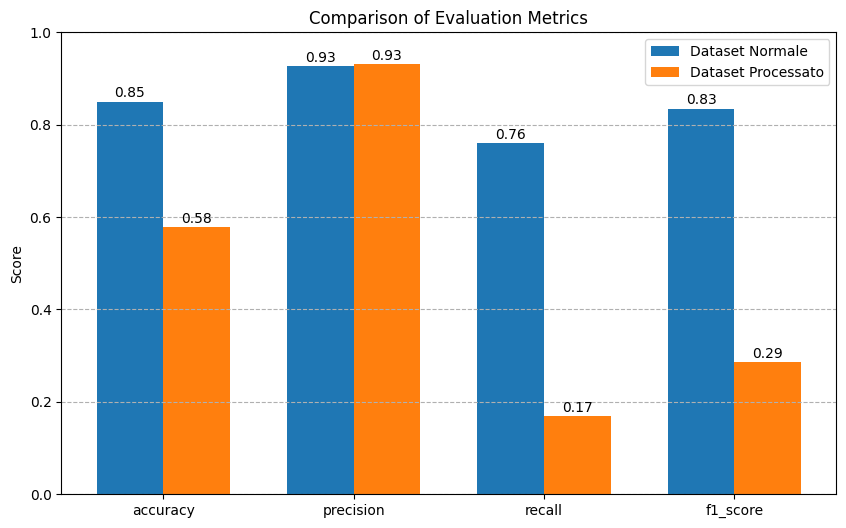

In [12]:
# Metrics to compare
metrics = ['accuracy', 'precision', 'recall', 'f1_score']

# Extract metric values for both datasets
results_normale_values = [evaluation_results_normale[metric] for metric in metrics]
results_processato_values = [evaluation_results_processato[metric] for metric in metrics]

x = range(len(metrics))  # x-axis positions

plt.figure(figsize=(10, 6))
width = 0.35  # Width of each bar

# Plot bars for the normal dataset (left)
plt.bar([i - width/2 for i in x], results_normale_values, width, label='Dataset Normale')

# Plot bars for the processed dataset (right)
plt.bar([i + width/2 for i in x], results_processato_values, width, label='Dataset Processato')

plt.ylabel('Score')
plt.title('Comparison of Evaluation Metrics')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)  # Metrics range between 0 and 1
plt.grid(axis='y', linestyle='--')

# Add value labels on top of each bar
for i in range(len(x)):
    plt.text(i - width/2, results_normale_values[i] + 0.01, f'{results_normale_values[i]:.2f}', ha='center')
    plt.text(i + width/2, results_processato_values[i] + 0.01, f'{results_processato_values[i]:.2f}', ha='center')

plt.show()